In [1]:
import pandas as pd
import os
import numpy as np
from scipy import stats
from collections import defaultdict
from pathlib import Path

In [2]:
from abag_affinity.utils.config import read_config, get_data_paths

plot_folder = "../../results/experiments/related_work_results"
Path(plot_folder).mkdir(parents=True, exist_ok=True)

config = read_config("../config.yaml")
abag_summary_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"]["abag_affinity"]["folder_path"], config["DATASETS"]["abag_affinity"]["summary"])

abag_df = pd.read_csv(abag_summary_path, index_col=0)
abag_df["validation"] = abag_df["validation"].astype(str).apply(lambda x: x.split(".")[0] if x != "nan" else "0")
abag_df.head()

,pdb,filename,chain_infos,-log(Kd),delta_g,validation,test
1bvk,1bvk,1bvk.pdb,"{'h': 0, 'l': 0, 'f': 1}",7.853872,-10.53000,2,False
1dqj,1dqj,1dqj.pdb,"{'h': 0, 'l': 0, 'c': 1}",8.543634,-11.45000,4,False
1e6j,1e6j,1e6j.pdb,"{'h': 0, 'l': 0, 'p': 1}",7.537602,-10.28000,4,False
1f90,1f90,1f90.pdb,"{'h': 0, 'l': 0, 'e': 1}",7.924453,-10.80000,0,True
1fsk,1fsk,1fsk.pdb,"{'h': 0, 'l': 0, 'g': 1}",9.619789,-13.12374,4,False


In [3]:
benchmark_summary_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"]["AntibodyBenchmark"]["folder_path"], config["DATASETS"]["AntibodyBenchmark"]["summary"])
benchmark_df = pd.read_csv(benchmark_summary_path, index_col=0)

benchmark_df["validation"] = benchmark_df["validation"].astype(str).apply(lambda x: x.split(".")[0] if x != "nan" else "0")
benchmark_df.head()

,pdb,filename,-log(Kd),Kd (nM),delta_g,chain_infos,validation,test
1s78,1s78,1S78.pdb,6.301030,500.000,-8.45,"{'d': 0, 'c': 0, 'a': 1}",0,True
2dd8,2dd8,2DD8.pdb,7.698970,20.000,-10.50,"{'h': 0, 'l': 0, 's': 1}",0,True
2fjg,2fjg,2FJG.pdb,7.698970,20.000,-10.92,"{'h': 0, 'l': 0, 'v': 1, 'w': 1}",0,True
2vxt,2vxt,2VXT.pdb,9.273273,0.533,-12.65,"{'h': 0, 'l': 0, 'i': 1}",0,True
2w9e,2w9e,2W9E.pdb,9.886057,0.130,-13.49,"{'h': 0, 'l': 0, 'a': 1}",0,True


### Helper Functions


In [5]:
delta_g_columns = ["bound_wildtype vs unbound_wildtype", "bound_wildtype vs unbound_relaxed", "bound_relaxed vs relaxed_unbound", "bound_relaxed vs relaxed_unbound_relaxed"]

In [8]:
def get_best_correlation(df, kd_col, delta_g_col, affinity_columns=delta_g_columns):
    correlations = {}
    for col in affinity_columns:
        # remove outiers 
        # outliers have a zscroe above 3
        mask_dg = df[col].notnull() & df[delta_g_col].notnull() 
        #np.abs(stats.zscore(df[col])) < 3
        #mask_dg &= np.abs(stats.zscore(df[col])) < 3
        
        mask_kd = df[col].notnull() & df[kd_col].notnull() 
        #np.abs(stats.zscore(df[col])) < 3
        #mask_kd &= np.abs(stats.zscore(df[col])) < 3
        
        correlations[col] = {
            kd_col: df[col][mask_dg].corr(df[kd_col][mask_dg].astype(float)),
            delta_g_col: df[col][mask_dg].corr(df[delta_g_col][mask_dg].astype(float))
        }
    best_combi = ()
    best_correlation = -1

    for type_ in correlations.keys():
        for measure in correlations[type_].keys():
            if correlations[type_][measure] > best_correlation:
                best_correlation = correlations[type_][measure]
                best_combi = (measure, type_)
                
    return best_combi, best_correlation

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

lin_reg = LinearRegression()

map_axis_label = {
    "rosetta_delta_g": "Prediction [ΔE]",
    "delta_g": "Label [ΔG]",
    "Kd (nM)": "Label [Kd]",
    "Interaction Energy": "Prediction [Interaction Energy]",
    "prediction": "Prediction [Kd]",
    'Label [-log(Kd)]': 'Label [-log(Kd)]',
    '-log(Kd)': 'Label [-log(Kd)]'

}


def plot_correlation(df, best_combi, linear_fit_results = True, fig_path: str = None):    
    mask = df[best_combi[0]].notnull() & df[best_combi[1]].notnull() 
    #mask &= np.abs(stats.zscore(df[best_combi[1]])) < 3
    masked_df = df[mask]
            
    masked_df.reset_index(level=0, inplace=True)
    
    x = masked_df[best_combi[0]]
    y = masked_df[best_combi[1]]
    
    plot = sns.jointplot(x=x, y=y, kind="reg")
    
    plot.set_axis_labels(map_axis_label[best_combi[0]], map_axis_label[best_combi[1]], fontsize=12)

    legend = ""

    r, p = stats.pearsonr(x, y) # stats.spearmanr(x, y)
    legend += 'r={:f}, p={:f}, '.format(r, p)
    
    
    if linear_fit_results:
        x = np.array(x)[..., np.newaxis]
        x = lin_reg.fit(X=x, y=y).predict(x)
    error = np.sqrt(np.mean((x-y)**2))
    legend += 'rmse={:f}, '.format(error)

    legend = legend[:-2]
    phantom, = plot.ax_joint.plot([], [], linestyle="", alpha=0)
    plot.ax_joint.legend([phantom], [legend])
    if fig_path is not None:
        plt.savefig(fig_path)
    plt.show()
    plt.close()
    

In [10]:
a = np.array([1,2])
a = a[np.newaxis, ...]
a

array([[1, 2]])

In [11]:
#results = pd.read_csv("/home/fabian/Desktop/Uni/Masterthesis/ag_binding_affinity/results/plots/residue/model_train/val_set_1/benchmark.csv", index_col=1)
#results.index.name = ""
#benchmark_scores_overlap_df = results.join(benchmark_df, how="inner")
##scores_overlap_df = scores_overlap_df[scores_overlap_df["delta_g"].notnull()]
#print("Total number of cases that overlap >>>", len(benchmark_scores_overlap_df))

#best_combi, best_correlation = get_best_correlation(benchmark_scores_overlap_df,"-log(Kd)","delta_g", affinity_columns=["prediction"])
#print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

#plot_correlation(benchmark_scores_overlap_df, best_combi)

## Rosetta Energy Function Results

In [12]:
force_field_results_folder = config["force_field_results"]

### Comparison of computed affinity values with benchmark values

In [13]:
benchmark_df = benchmark_df[benchmark_df["delta_g"].notnull()]
benchmark_df["delta_g"] = benchmark_df["delta_g"].astype(float)
benchmark_df["Kd (nM)"] = benchmark_df["Kd (nM)"].astype(float)

In [14]:
#ToDO: load rosetta computed values
ref15_benchmark_df = pd.DataFrame()

In [15]:
benchmark_overlap_df = ref15_benchmark_df.join(benchmark_df, how="inner")
print("Total number of cases that overlap >>>", len(benchmark_overlap_df))

Total number of cases that overlap >>> 0


In [16]:
if len(benchmark_overlap_df) > 0:
    best_combi, best_correlation = get_best_correlation(benchmark_overlap_df,"affinity","delta_g")
    print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

In [17]:
if len(benchmark_overlap_df) > 0:
    plot_correlation(benchmark_overlap_df, best_combi)

### Comparison of computed affinity values with SAbDab values

In [18]:
#ToDO: load rosetta computed values for abag affinity
ref15_abag_df = pd.DataFrame()

In [19]:
abag_overlap_df = ref15_abag_df.join(abag_df, how="inner")
abag_overlap_df = abag_overlap_df[abag_overlap_df["delta_g"].notnull() & abag_overlap_df["-log(Kd)"].notnull()]
print("Total number of cases that overlap >>>", len(abag_overlap_df))

Total number of cases that overlap >>> 0


In [20]:
if len(abag_overlap_df) > 0:
    best_combi, best_correlation = get_best_correlation(abag_overlap_df,"affinity","delta_g")
    print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

In [21]:
if len(abag_overlap_df) > 0:
    plot_correlation(abag_overlap_df, best_combi)

### Results using Benchmark Script and Rosetta Suite 2017.219

In [22]:
def get_scores(path):
    # get pdb_ids
    with open(os.path.join(path, "data_points.txt")) as f:
        pdbs = f.readlines()
    pdbs = [ pdb.split(",")[0].strip().lower() for pdb in pdbs]

    # get delta g scores
    with open(os.path.join(path, "results.txt")) as f:
        scores = f.readlines()

    results = defaultdict(dict)
    pdb_idx = 0
    for score in scores:
        if score == 'Antibody\n':
            score_type = "Antibody"
        if score == 'Antigen\n':
            score_type = "Antigen"
        if score == 'Complex\n':
            score_type = "Complex"
        if score in ["\n", 'Antibody\n', 'Antigen\n', 'Complex\n', 'fa_atr\n', 'score\n']:
            pdb_idx = 0
            continue
            
        results[pdbs[pdb_idx]][score_type] = score.strip()
        pdb_idx += 1

    rosetta_scores = pd.DataFrame(results.values())
    rosetta_scores.index = results.keys()
    rosetta_scores = rosetta_scores.astype(float)
    rosetta_scores["rosetta_delta_g"] = rosetta_scores["Complex"] - rosetta_scores["Antibody"] - rosetta_scores["Antigen"]
    
    return rosetta_scores

In [23]:
benchmark_rosetta_scores = get_scores(os.path.join(force_field_results_folder, "guest_REF15", "antibody_benchmark"))

In [24]:
benchmark_scores_overlap_df = benchmark_rosetta_scores.join(benchmark_df, how="inner")
#scores_overlap_df = scores_overlap_df[scores_overlap_df["delta_g"].notnull()]
print("Total number of cases that overlap >>>", len(benchmark_scores_overlap_df))

Total number of cases that overlap >>> 42


In [25]:
best_combi, best_correlation = get_best_correlation(benchmark_scores_overlap_df,"Kd (nM)","delta_g", affinity_columns=["rosetta_delta_g"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between delta_g and rosetta_delta_g of 0.33333364896916134


In [36]:
abag_scores_overlap_df

In [32]:
benchmark_scores_overlap_df['Label [-log(Kd)]'] = benchmark_scores_overlap_df['Kd (nM)'].apply(lambda x: -np.log10(x))

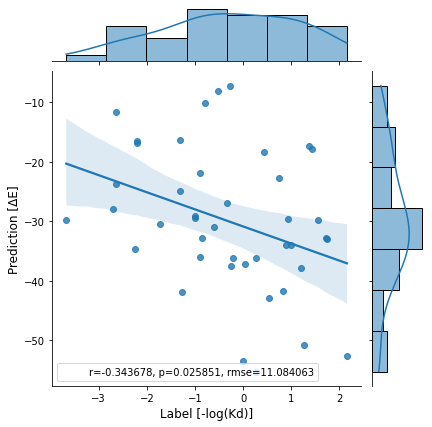

In [40]:
plot_correlation(benchmark_scores_overlap_df, best_combi, fig_path=os.path.join(plot_folder, "ab_benchmark_ref15_results.png"))

#### Using all abag_affinity pdbs

In [42]:
abag_rosetta_scores = get_scores(os.path.join(force_field_results_folder, "guest_REF15", "abag_affinity_dataset"))

In [43]:
abag_rosetta_scores = abag_rosetta_scores[abag_rosetta_scores["rosetta_delta_g"] < 200]

In [44]:
abag_scores_overlap_df = abag_rosetta_scores.join(abag_df, how="inner")
abag_scores_overlap_df = abag_scores_overlap_df[abag_scores_overlap_df["delta_g"].notnull()]
print("Total number of cases that overlap >>>", len(abag_scores_overlap_df))

Total number of cases that overlap >>> 367


In [46]:
best_combi, best_correlation = get_best_correlation(abag_scores_overlap_df,"-log(Kd)","delta_g", affinity_columns=["rosetta_delta_g"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between delta_g and rosetta_delta_g of 0.11821387659350871


In [48]:
best_combi = ('-log(Kd)', 'rosetta_delta_g')

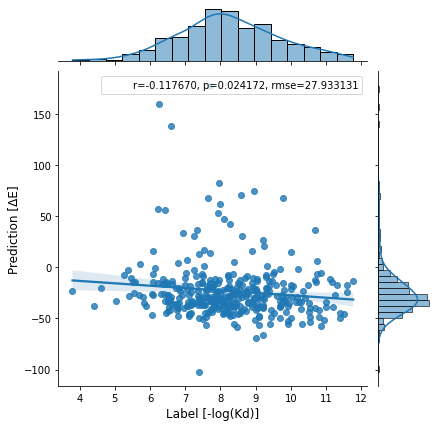

In [51]:
plot_correlation(abag_scores_overlap_df, best_combi)

#### Using only the AbAg-Affinity test set

In [29]:
validation_set_df = abag_df[abag_df["validation"] == "0"]

In [30]:
validation_scores_overlap_df = abag_rosetta_scores.join(validation_set_df, how="inner")
validation_scores_overlap_df = validation_scores_overlap_df[validation_scores_overlap_df["-log(Kd)"].notnull()]
print("Total number of cases that overlap >>>", len(validation_scores_overlap_df))

Total number of cases that overlap >>> 49


In [31]:
validation_scores_overlap_df.describe()

,Antibody,Antigen,Complex,rosetta_delta_g,-log(Kd),delta_g
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,152.792673,491.255204,614.204898,-29.842980,8.107235,-11.061206
std,1020.072812,1151.619168,2088.321813,12.475386,1.268406,1.730349
min,-426.701000,-244.526000,-636.677000,-55.588000,5.886057,-15.271103
25%,-278.624000,13.749000,-362.040000,-37.609000,7.309804,-12.120000
50%,-98.711000,100.391000,101.197000,-32.115000,8.060481,-11.010000
75%,150.290000,452.097000,620.014000,-24.482000,8.886057,-9.972357
max,6501.306000,6861.749000,13354.905000,5.805000,11.193820,-8.030000


In [32]:
best_combi, best_correlation = get_best_correlation(validation_scores_overlap_df,"-log(Kd)","delta_g", affinity_columns=["rosetta_delta_g"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between delta_g and rosetta_delta_g of 0.14572588943732112


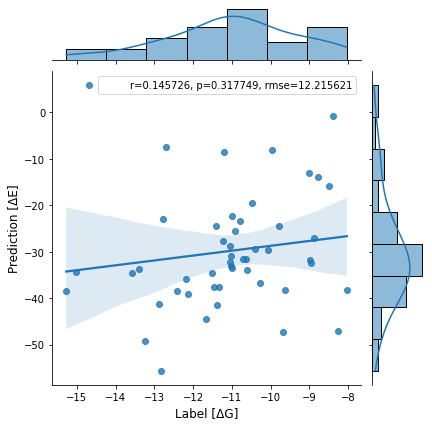

In [33]:
plot_correlation(validation_scores_overlap_df, best_combi, fig_path=os.path.join(plot_folder, "abag_affinity_ref15_results.png"))

## FoldX Results

#### Comparison of computed affinity values with Benchmark values

In [34]:
foldx_summary_df = pd.read_csv("../../data/AbDb/foldx_results.csv")
foldx_summary_df = foldx_summary_df.set_index("pdb_id")

benchmark_foldx_overlap_df = foldx_summary_df.join(benchmark_df, how="inner", lsuffix="_abdb")
print("Total number of cases that overlap >>>", len(benchmark_foldx_overlap_df))

Total number of cases that overlap >>> 29


In [35]:
best_combi, best_correlation = get_best_correlation(benchmark_foldx_overlap_df,"Kd (nM)","delta_g", ["Interaction Energy", "Interface Residues"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between delta_g and Interface Residues of 0.0858044805760254


#### Comparison of computed affinity values with AbAg-Affinity values

In [36]:
abag_foldx_overlap_df = foldx_summary_df.join(abag_df, how="inner")
abag_foldx_overlap_df = abag_foldx_overlap_df[abag_foldx_overlap_df["delta_g"].notnull() & abag_foldx_overlap_df["-log(Kd)"].notnull()]
print("Total number of cases that overlap >>>", len(abag_foldx_overlap_df))

Total number of cases that overlap >>> 318


In [37]:
best_combi, best_correlation = get_best_correlation(abag_foldx_overlap_df,"-log(Kd)","delta_g", ["Interaction Energy", "Interface Residues"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between delta_g and Interaction Energy of 0.13419830711645686


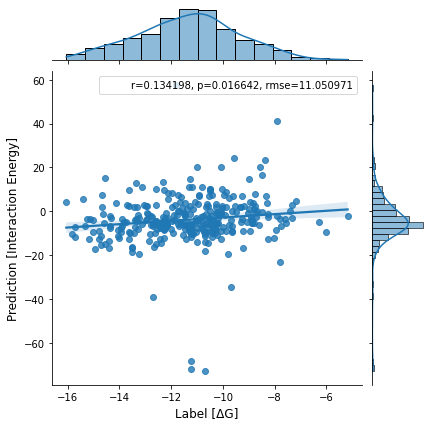

In [38]:
plot_correlation(abag_foldx_overlap_df, best_combi)

## CSM-AB Results

### Comparison of CSM-AB with Benchmark values

In [39]:
csmab_scores_df = pd.read_csv("../../../other_repos/CSM-AB/results.csv")
csmab_scores_df["pdb_id"] = csmab_scores_df["pdb_id"].apply(lambda x: x.lower())
csmab_scores_df = csmab_scores_df.set_index("pdb_id")

In [40]:
csmab_overlap_df = csmab_scores_df.join(benchmark_df, how="inner")
csmab_overlap_df = csmab_overlap_df[["prediction", "delta_g", "Kd (nM)"]]

In [41]:
best_combi, best_correlation = get_best_correlation(csmab_overlap_df, "delta_g","Kd (nM)", ["prediction"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between delta_g and prediction of 0.23920751239699087


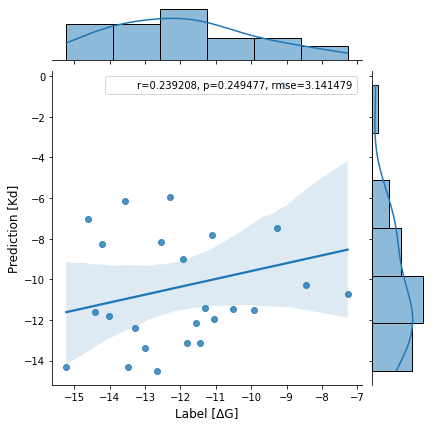

In [42]:
plot_correlation(csmab_overlap_df, best_combi)

#### Removing training data

In [43]:
training_data = pd.read_csv("../../../other_repos/CSM-AB/1_training.csv")["pdb"].values

csmab_overlap_df = csmab_overlap_df[~csmab_overlap_df.index.isin(training_data)]
print("Number of samples not in Training data {}".format(len(csmab_overlap_df)))

Number of samples not in Training data 6


In [44]:
best_combi, best_correlation = get_best_correlation(csmab_overlap_df, "delta_g","Kd (nM)", ["prediction"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between Kd (nM) and prediction of -0.4154609983220814


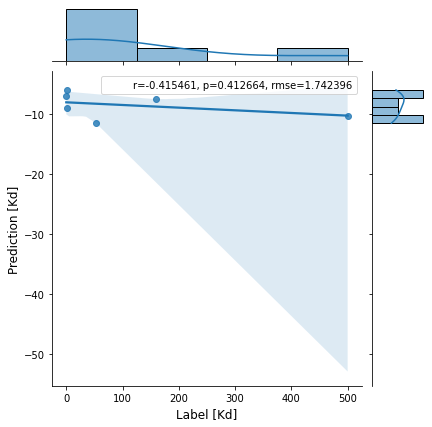

In [45]:
plot_correlation(csmab_overlap_df, best_combi)

### Comparison of CSM-AB with AbAg-affinity values

In [46]:
csmab_abag_overlap_df = csmab_scores_df.join(abag_df, how="inner")
csmab_abag_overlap_df = csmab_abag_overlap_df[["prediction", "-log(Kd)", "delta_g"]]

In [47]:
best_combi, best_correlation = get_best_correlation(csmab_abag_overlap_df, "delta_g","-log(Kd)", ["prediction"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between delta_g and prediction of 0.35240712943828006


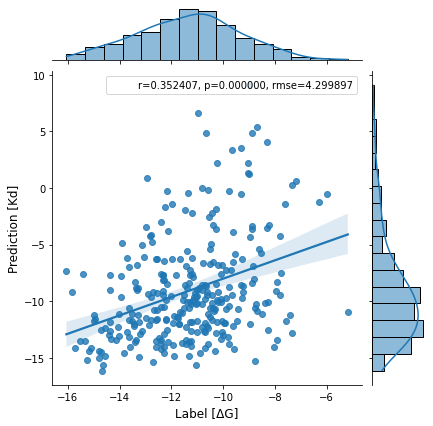

In [48]:
plot_correlation(csmab_abag_overlap_df, best_combi)

#### Removing training data


In [49]:
training_data = pd.read_csv("../../../other_repos/CSM-AB/1_training.csv")["pdb"].values

csmab_abag_overlap_df = csmab_abag_overlap_df[~csmab_abag_overlap_df.index.isin(training_data)]

In [50]:
print("Number of samples not in Training data {}".format(len(csmab_abag_overlap_df)))

Number of samples not in Training data 110


In [51]:
best_combi, best_correlation = get_best_correlation(csmab_abag_overlap_df, "delta_g","-log(Kd)", ["prediction"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between delta_g and prediction of 0.1870682110943038


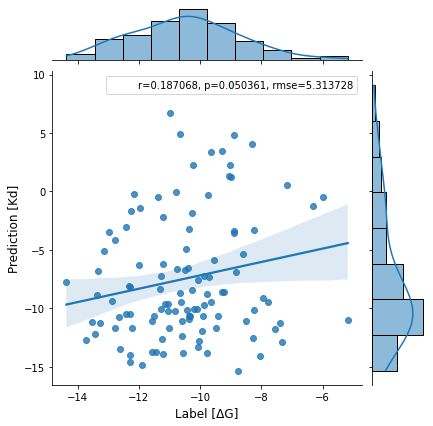

In [52]:
plot_correlation(csmab_abag_overlap_df, best_combi)

#### Using only AbAg Affinity Testset

In [53]:
validation_set_non_training = csmab_scores_df.join(validation_set_df, how="inner")

validation_set_non_training = validation_set_non_training[~validation_set_non_training.index.isin(training_data)]

print("Number of samples not in Training data {}".format(len(validation_set_non_training)))

Number of samples not in Training data 11


In [54]:
best_combi, best_correlation = get_best_correlation(validation_set_non_training, "delta_g","-log(Kd)", ["prediction"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between -log(Kd) and prediction of 0.1655579630750018


KeyError: '-log(Kd)'

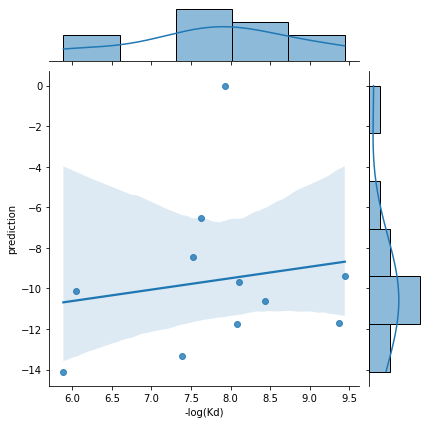

In [55]:
plot_correlation(validation_set_non_training, best_combi)